In [2]:
pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.6/280.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 4.9 MB/s eta 0:00:00


Loading MOGP Assets...
Simulating virtual experiments...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


SUCCESS: Generated 'MOGP_Pareto_Fixed_Layout.pdf' with corrected label positioning.


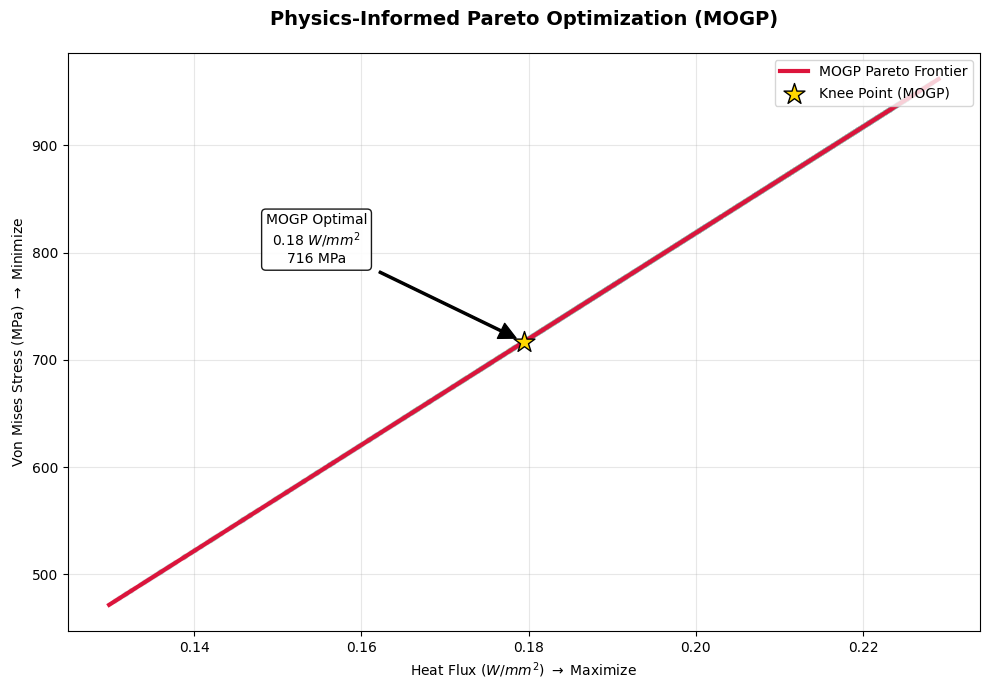

In [3]:
import torch
import gpytorch
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. DEFINE CLASS ARCHITECTURE
# ==========================================
class MOGP_Surrogate(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MOGP_Surrogate, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=5
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=6)
            ),
            num_tasks=5,
            rank=1
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

# ==========================================
# 2. LOAD ASSETS
# ==========================================
print("Loading MOGP Assets...")
assets = joblib.load('mogp_assets.pkl')

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=5)
dummy_x = torch.zeros(1, 6)
dummy_y = torch.zeros(1, 5)
model = MOGP_Surrogate(dummy_x, dummy_y, likelihood)

model.load_state_dict(assets['model_state'])
likelihood.load_state_dict(assets['likelihood_state'])

# Robust Key Retrieval
X_scaler = assets.get('X_scaler') or assets.get('x_scaler')
y_scaler = assets.get('y_scaler') or assets.get('Y_scaler')
materials_dict = assets.get('materials') or assets.get('materials_dict')

model.eval()
likelihood.eval()

# ==========================================
# 3. GENERATE VIRTUAL DESIGN SPACE
# ==========================================
n_samples = 10000
power = np.random.uniform(50, 300, n_samples)
speed = np.random.uniform(5, 50, n_samples)
radius = np.random.uniform(0.8, 1.5, n_samples)

virtual_rows = []
print("Simulating virtual experiments...")

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    for material, props in materials_dict.items():
        mat_props = np.tile(props, (n_samples, 1))
        process_params = np.column_stack([power, speed, radius])
        X_raw = np.hstack([process_params, mat_props])

        X_scaled = X_scaler.transform(X_raw)
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

        posterior = likelihood(model(X_tensor))
        mean_real = y_scaler.inverse_transform(posterior.mean.numpy())

        # Index 1 = Von Mises, Index 4 = Heat Flux
        temp_df = pd.DataFrame({
            'Power': power,
            'Speed': speed,
            'Material': material,
            'Stress_Pred': mean_real[:, 1],
            'Flux_Pred': mean_real[:, 4]
        })
        virtual_rows.append(temp_df)

df_virtual = pd.concat(virtual_rows, ignore_index=True)

# ==========================================
# 4. PARETO LOGIC
# ==========================================
def get_pareto_mask(costs):
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0
    while next_point_index < len(costs):
        nondominated_point_mask = np.any(costs < costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index]) + 1
    is_efficient_mask = np.zeros(n_points, dtype=bool)
    is_efficient_mask[is_efficient] = True
    return is_efficient_mask

# Minimize Stress, Negate Flux to Minimize
costs = df_virtual[['Stress_Pred', 'Flux_Pred']].values.copy()
costs[:, 1] = -costs[:, 1]

mask = get_pareto_mask(costs)
df_pareto = df_virtual[mask].sort_values('Flux_Pred')

# Knee Point Calculation
s_norm = (df_pareto['Stress_Pred'] - df_pareto['Stress_Pred'].min()) / (df_pareto['Stress_Pred'].max() - df_pareto['Stress_Pred'].min())
f_norm = (df_pareto['Flux_Pred'] - df_pareto['Flux_Pred'].min()) / (df_pareto['Flux_Pred'].max() - df_pareto['Flux_Pred'].min())
dist = np.sqrt(s_norm**2 + (1 - f_norm)**2)
knee_point = df_pareto.loc[dist.idxmin()]

# ==========================================
# 5. FIXED PLOTTING (Dynamic Positioning)
# ==========================================
plt.figure(figsize=(10, 7))

# 1. Plot Cloud & Frontier
sns.scatterplot(data=df_virtual.sample(5000), x='Flux_Pred', y='Stress_Pred',
                hue='Material', palette='viridis', alpha=0.1, legend=False, s=15)
plt.plot(df_pareto['Flux_Pred'], df_pareto['Stress_Pred'],
         color='crimson', linewidth=3, label='MOGP Pareto Frontier')

# 2. Plot Knee Point
plt.scatter(knee_point['Flux_Pred'], knee_point['Stress_Pred'],
            color='gold', s=250, marker='*', edgecolors='k', zorder=5, label='Knee Point (MOGP)')

# 3. Dynamic Annotation Positioning
# Calculate span of the axes
x_span = df_virtual['Flux_Pred'].max() - df_virtual['Flux_Pred'].min()
y_span = df_virtual['Stress_Pred'].max() - df_virtual['Stress_Pred'].min()

# Position: Shift Left by 20% of X-span, Shift Up by 15% of Y-span
# This keeps it relative to the data scale, avoiding overlap with title (Top) or borders.
text_x = knee_point['Flux_Pred'] - (x_span * 0.25)
text_y = knee_point['Stress_Pred'] + (y_span * 0.15)

# Ensure text doesn't go below min stress or above max stress
text_y = max(min(text_y, df_virtual['Stress_Pred'].max() * 0.9), df_virtual['Stress_Pred'].min())

plt.annotate(f"MOGP Optimal\n{knee_point['Flux_Pred']:.2f} $W/mm^2$\n{int(knee_point['Stress_Pred'])} MPa",
             xy=(knee_point['Flux_Pred'], knee_point['Stress_Pred']),
             xytext=(text_x, text_y),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.9),
             fontsize=10, ha='center')

# 4. Styling
plt.xlabel('Heat Flux ($W/mm^2$) $\\rightarrow$ Maximize')
plt.ylabel('Von Mises Stress (MPa) $\\rightarrow$ Minimize')
plt.title('Physics-Informed Pareto Optimization (MOGP)', fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()

plt.savefig('MOGP_Pareto_Fixed_Layout.pdf', dpi=300)
print("SUCCESS: Generated 'MOGP_Pareto_Fixed_Layout.pdf' with corrected label positioning.")